# Lendo a base de dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

# Paper = https://drive.google.com/file/d/1lUtlu1vdGMymo8lkOTl_cftfcPDJMk0X/view?usp=sharing

In [2]:
df = pd.read_csv('datasets/preprocessed_df.csv')
df

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,meal,country,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,kids,total_guests,is_family,total_stays
0,Resort Hotel,0,342,7,27,0,0,2,BB,PRT,...,0.00,0,0,Check-Out,2015-07-01,2015-07-01,0.0,2.0,0,0
1,Resort Hotel,0,400,7,27,0,0,2,BB,PRT,...,0.00,0,0,Check-Out,2015-07-01,2015-07-01,0.0,2.0,0,0
2,Resort Hotel,0,7,7,27,0,1,1,BB,GBR,...,75.00,0,0,Check-Out,2015-07-02,2015-07-01,0.0,1.0,0,1
3,Resort Hotel,0,13,7,27,0,1,1,BB,GBR,...,75.00,0,0,Check-Out,2015-07-02,2015-07-01,0.0,1.0,0,1
4,Resort Hotel,0,14,7,27,0,2,2,BB,GBR,...,98.00,0,1,Check-Out,2015-07-03,2015-07-01,0.0,2.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86998,City Hotel,0,23,8,35,2,5,2,BB,BEL,...,96.14,0,0,Check-Out,2017-09-06,2017-08-30,0.0,2.0,0,7
86999,City Hotel,0,102,8,35,2,5,3,BB,FRA,...,225.43,0,2,Check-Out,2017-09-07,2017-08-31,0.0,3.0,0,7
87000,City Hotel,0,34,8,35,2,5,2,BB,DEU,...,157.71,0,4,Check-Out,2017-09-07,2017-08-31,0.0,2.0,0,7
87001,City Hotel,0,109,8,35,2,5,2,BB,GBR,...,104.40,0,0,Check-Out,2017-09-07,2017-08-31,0.0,2.0,0,7


In [3]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_Room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date', 'kids',
       'total_guests', 'is_family', 'total_stays'],
      dtype='object')

In [4]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_month                  int64
arrival_date_week_number            int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_Room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             float64
company                           float64
days_in_waiting_list                int64
customer_type                      object
adr                               

In [5]:
X = df[['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled','total_guests', 'is_family', 'total_stays']]
y = df['is_canceled']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
rf = RandomForestClassifier(random_state = 42)

In [9]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv = 5)
CV_rfc.fit(X_train, y_train)

In [11]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

In [12]:
rf = RandomForestClassifier(criterion = 'gini', max_depth = 8, max_features = 'sqrt', n_estimators = 200, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [13]:
score = accuracy_score(y_test, y_pred)
print(score)

0.7441956691646361


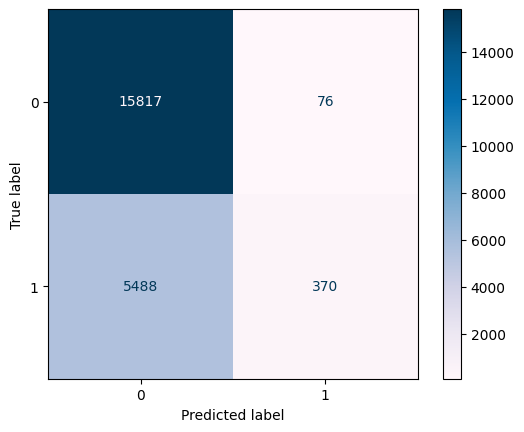

In [14]:
matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='PuBu')

# SVM

In [11]:
from sklearn.svm import SVC

In [12]:
svc = SVC(kernel = 'rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [13]:
score = accuracy_score(y_test, y_pred)
print(score)

0.7306790492391154


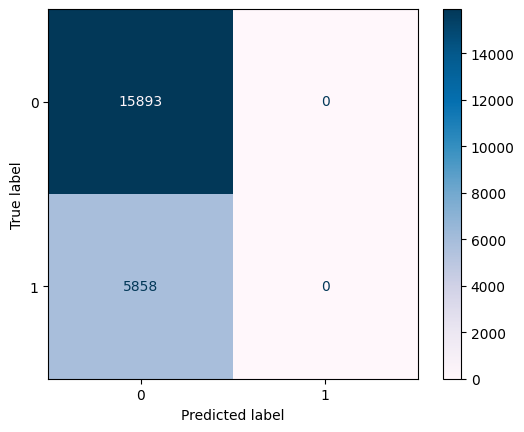

In [14]:
matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='PuBu')